In [3]:
import os
import pickle
import glob
import random
import time

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import scipy.stats as st
# from sklearn import ensemble, svm
# from sklearn.metrics import balanced_accuracy_score, classification_report
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import RobustScaler, StandardScaler

import npc_lims
from npc_sessions import DynamicRoutingSession
# import npc_sessions.utils
from dynamic_routing_analysis import spike_utils, decoding_utils


In [2]:
all_ephys_sessions = tuple(s for s in npc_lims.get_session_info(is_ephys=True, is_uploaded=True, is_annotated=True))

In [1]:
session_projects={
    'session':[],
    'project':[]
}
for ss in all_ephys_sessions:
    session_projects['session'].append(str(ss.id+''))
    session_projects['project'].append(str(ss.project))
# session_list=list(decoder_results.keys())
# for ss in session_list:
#     session=DynamicRoutingSession(ss)
#     session_projects['session'].append(session.project)

session_projects=pd.DataFrame(session_projects)
session_projects

NameError: name 'all_ephys_sessions' is not defined

In [85]:
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_spikes_LDA"

In [86]:
#loop through decoder results, append to dict
files=glob.glob(os.path.join(loadpath,'*_decoding_results*.pkl'))

decoder_results={}
for ii,ff in enumerate(files[:]):
    with open(ff,'rb') as f:
        data=pickle.load(f)
    session_id=ff.split('\\')[-1].split('_decoding')[0]
    decoder_results[session_id]=data[list(data.keys())[0]]


In [51]:
# session_list=list(decoder_results.keys())

In [52]:
# session_id=session_list[0]
# shifts=decoder_results[session_id]['shifts']
# shift_inds=np.arange(len(shifts))
# np.nanmean(np.vstack(decoder_results[session_id]['results']['all']['shift'][np.where(shifts==1)[0][0]]['coefs']),axis=0)

array([-0.00341401,  0.00785911,  0.00070185, ..., -0.00751936,
       -0.00122147, -0.00364653])

In [87]:
session_list=list(decoder_results.keys())
use_half_shifts=False
has_repeats=True

all_bal_acc={}
unit_decoding_weight_dict={
    'unit_id':[],
    'session_id':[],
    'project':[],
    'area':[],
    'raw_coef_area':[],
    'null_coef_area':[],
    'adjusted_coef_area':[],
    'abs_adj_coef_area':[],
    'rank_area':[],
    'raw_coef_session':[],
    'null_coef_session':[],
    'adjusted_coef_session':[],
    'abs_adj_coef_session':[],
    'rank_session':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
}

#loop through decoder results
for session_id in session_list:
    session_info=npc_lims.get_session_info(session_id)
    try:
        performance=pd.read_parquet(
                    npc_lims.get_cache_path('performance',session_info.id,version='any')
                )
    except:
        continue

    if session_info.is_annotated==False:
        continue
    
    shifts=decoder_results[session_id]['shifts']
    shift_inds=np.arange(len(shifts))
    areas=decoder_results[session_id]['areas']

    #get all unit ids
    session_unit_ids=decoder_results[session_id]['results']['all']['unit_ids']
    
    all_coefs=[]

    #get session wide coefs + rank
    for sh in shift_inds:
        all_coefs.append(np.nanmean(np.vstack(decoder_results[session_id]['results']['all']['shift'][sh]['coefs']),axis=0))

    true_coefs=all_coefs[np.where(shifts==1)[0][0]]
    null_coefs=np.nanmedian(np.stack(all_coefs),axis=0)
    adjusted_coefs=true_coefs-null_coefs

    abs_adj_coefs=np.abs(adjusted_coefs)
    session_rank=np.argsort(abs_adj_coefs)

    session_unit_coefs=pd.DataFrame({
        'unit_id':session_unit_ids,
        'raw_coef_session':true_coefs,
        'null_coef_session':null_coefs,
        'adjusted_coef_session':adjusted_coefs,
        'abs_adj_coef_session':abs_adj_coefs,
        'rank_session':session_rank
    })
        
    #loop through areas
    for aa in areas:
        if aa not in decoder_results[session_id]['results'].keys():
            continue
        if aa=='all':
            continue
        area_unit_ids=decoder_results[session_id]['results'][aa]['unit_ids']
        area_inds=np.where(np.isin(session_unit_ids,area_unit_ids))[0]
        area_coefs=[]
        for sh in shift_inds:
            area_coefs.append(np.nanmean(np.vstack(decoder_results[session_id]['results'][aa]['shift'][sh]['coefs']),axis=0))
        true_coefs=area_coefs[np.where(shifts==1)[0][0]]
        null_coefs=np.nanmedian(np.stack(area_coefs),axis=0)
        adjusted_coefs=true_coefs-null_coefs
        abs_adj_coefs=np.abs(adjusted_coefs)
        area_rank=np.argsort(abs_adj_coefs)

        #find matching session coefs and ranks
        session_units_area=session_unit_coefs.query('unit_id in @area_unit_ids')

        area_unit_coefs=pd.DataFrame({
            'unit_id':area_unit_ids,
            'raw_coef_area':true_coefs,
            'null_coef_area':null_coefs,
            'adjusted_coef_area':adjusted_coefs,
            'abs_adj_coef_area':abs_adj_coefs,
            'rank_area':area_rank
        })

        #append to unit_decoding_weight_dict
        unit_decoding_weight_dict['unit_id'].extend(area_unit_ids)
        unit_decoding_weight_dict['session_id'].extend([session_id]*len(area_unit_ids))
        unit_decoding_weight_dict['project'].extend([session_info.project]*len(area_unit_ids))
        unit_decoding_weight_dict['area'].extend([aa]*len(area_unit_ids))
        unit_decoding_weight_dict['raw_coef_area'].extend(area_unit_coefs['raw_coef_area'])
        unit_decoding_weight_dict['null_coef_area'].extend(area_unit_coefs['null_coef_area'])
        unit_decoding_weight_dict['adjusted_coef_area'].extend(area_unit_coefs['adjusted_coef_area'])
        unit_decoding_weight_dict['abs_adj_coef_area'].extend(area_unit_coefs['abs_adj_coef_area'])
        unit_decoding_weight_dict['rank_area'].extend(area_unit_coefs['rank_area'])
        unit_decoding_weight_dict['raw_coef_session'].extend(session_units_area['raw_coef_session'])
        unit_decoding_weight_dict['null_coef_session'].extend(session_units_area['null_coef_session'])
        unit_decoding_weight_dict['adjusted_coef_session'].extend(session_units_area['adjusted_coef_session'])
        unit_decoding_weight_dict['abs_adj_coef_session'].extend(session_units_area['abs_adj_coef_session'])
        unit_decoding_weight_dict['rank_session'].extend(session_units_area['rank_session'])
        unit_decoding_weight_dict['cross_modal_dprime'].extend([performance['cross_modal_dprime'].mean()]*len(area_unit_ids))
        unit_decoding_weight_dict['n_good_blocks'].extend([np.sum(performance['cross_modal_dprime']>1.0)]*len(area_unit_ids))
    print(session_id,'completed')

unit_decoding_weight_df=pd.DataFrame(unit_decoding_weight_dict)
# unit_decoding_weight_df.to_pickle(os.path.join(loadpath,'combined','unit_decoding_weight_df.pkl'))
unit_decoding_weight_df.to_csv(os.path.join(loadpath,'combined','unit_decoding_weight_df.csv'))

    #get area unit ids

    #loop through area units

    #get area-specific coefs + rank

    #append area-specific and session wide coefs + ranks





#get area-specific coefs and whole-session coefs, plus ranks

#how to get coefs:
##1 - loop through linear shifts
##2 - average over 5-folds within each shift
##3 - subtract median null from true aligned coefs

#add to a unit table with unit id, session id, project, area, and coefs/ranks


620263_2022-07-26_0 completed
620263_2022-07-27_0 completed
620264_2022-08-02_0 completed
626791_2022-08-15_0 completed
626791_2022-08-16_0 completed
626791_2022-08-17_0 completed
628801_2022-09-19_0 completed
636397_2022-09-26_0 completed
636397_2022-09-27_0 completed
636766_2023-01-23_0 completed
636766_2023-01-24_0 completed
636766_2023-01-25_0 completed
636766_2023-01-26_0 completed
644547_2022-12-05_0 completed
644547_2022-12-06_0 completed
644864_2023-01-30_0 completed
644864_2023-01-31_0 completed
644866_2023-02-07_0 completed
644866_2023-02-08_0 completed
644866_2023-02-09_0 completed
644866_2023-02-10_0 completed
644867_2023-02-20_0 completed
644867_2023-02-22_0 completed
644867_2023-02-23_0 completed
646318_2023-01-17_0 completed
646318_2023-01-18_0 completed
649943_2023-02-13_0 completed
649943_2023-02-14_0 completed
649943_2023-02-15_0 completed
649943_2023-02-16_0 completed
649944_2023-02-27_0 completed
649944_2023-02-28_0 completed
660023_2023-08-09_0 completed
662892_202

In [42]:
SVC=pd.read_csv(r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_spikes_SVC\combined\unit_decoding_weight_df.csv")
LDA=pd.read_csv(r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_spikes_LDA\combined\unit_decoding_weight_df.csv")

#remove _probe from area names
probes=['A','B','C','D','E','F']
for probe in probes:
    SVC['area']=SVC['area'].str.replace('_probe'+probe,'')
    LDA['area']=LDA['area'].str.replace('_probe'+probe,'')

#add normalized ranks per sessions
SVC['rank_session_norm']=SVC.groupby('session_id')['rank_session'].rank(pct=True)
LDA['rank_session_norm']=LDA.groupby('session_id')['rank_session'].rank(pct=True)

In [41]:
SVC.groupby('session_id')['rank_session'].rank(pct=True)

0         0.272822
1         0.060166
2         0.835062
3         0.688797
4         0.765560
            ...   
115490    0.833887
115491    0.940864
115492    0.140199
115493    0.006645
115494    0.786711
Name: rank_session, Length: 115495, dtype: float64

In [57]:
SVC

,Unnamed: 0,unit_id,session_id,project,area,raw_coef_area,null_coef_area,adjusted_coef_area,abs_adj_coef_area,rank_area,raw_coef_session,null_coef_session,adjusted_coef_session,abs_adj_coef_session,rank_session,cross_modal_dprime,n_good_blocks,rank_session_norm
0,0,620263_2022-07-26_F-610,620263_2022-07-26_0,TempletonPilotSession,ACAd,-0.033484,-0.005169,-0.028315,0.028315,41,-0.015873,0.008020,-0.023893,0.023893,263,NaN,0,0.272822
1,1,620263_2022-07-26_F-449,620263_2022-07-26_0,TempletonPilotSession,ACAd,-0.024385,-0.046075,0.021690,0.021690,30,0.018040,-0.005815,0.023855,0.023855,57,NaN,0,0.060166
2,2,620263_2022-07-26_F-194,620263_2022-07-26_0,TempletonPilotSession,ACAd,-0.132023,-0.151242,0.019219,0.019219,8,-0.003774,-0.007578,0.003804,0.003804,816,NaN,0,0.835062
3,3,620263_2022-07-26_F-196,620263_2022-07-26_0,TempletonPilotSession,ACAd,-0.085351,-0.042744,-0.042607,0.042607,32,-0.035355,-0.028460,-0.006895,0.006895,672,NaN,0,0.688797
4,4,620263_2022-07-26_F-197,620263_2022-07-26_0,TempletonPilotSession,ACAd,-0.441948,-0.388090,-0.053857,0.053857,22,0.011205,0.007068,0.004137,0.004137,748,NaN,0,0.765560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115490,115490,703333_2024-04-11_F-583,703333_2024-04-11_0,DynamicRouting,MOs,-0.046597,-0.042421,-0.004176,0.004176,59,0.000725,0.004534,-0.003809,0.003809,1277,0.644287,1,0.833887
115491,115491,703333_2024-04-11_F-590,703333_2024-04-11_0,DynamicRouting,MOs,-0.238378,-0.163268,-0.075110,0.075110,34,-0.003326,-0.001515,-0.001810,0.001810,1443,0.644287,1,0.940864
115492,115492,703333_2024-04-11_F-591,703333_2024-04-11_0,DynamicRouting,MOs,-0.088075,-0.071491,-0.016585,0.016585,39,0.002302,0.001526,0.000776,0.000776,216,0.644287,1,0.140199
115493,115493,703333_2024-04-11_F-610,703333_2024-04-11_0,DynamicRouting,MOs,0.036167,0.093973,-0.057806,0.057806,103,0.013836,0.006667,0.007169,0.007169,9,0.644287,1,0.006645


In [18]:
# sel_session=SVC.query('project=="DynamicRouting"')['session_id'].unique()[25]

# SVC_session=SVC.query('session_id==@sel_session')

# session_areas=SVC_session['area'].unique()

# for aa in session_areas:
#     SVC_area=SVC_session.query('area==@aa')


In [26]:
merged=pd.merge(SVC,LDA,on=['unit_id','session_id','project','area'],suffixes=('_SVC','_LDA'),how='outer')

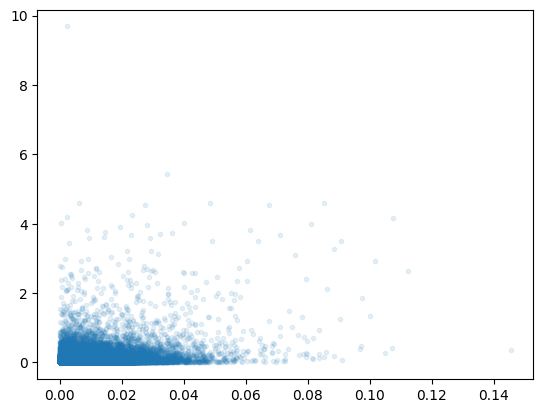

In [27]:
fig,ax=plt.subplots(1,1)

ax.plot(merged['abs_adj_coef_session_SVC'],merged['abs_adj_coef_session_LDA'],'.',alpha=0.1)

In [28]:
#find pearson correlation
not_nan_merged=merged.query('~abs_adj_coef_area_SVC.isna() and ~abs_adj_coef_area_SVC.isna()')

r,p=st.pearsonr(not_nan_merged['abs_adj_coef_area_SVC'],not_nan_merged['abs_adj_coef_area_LDA'])
print(r,p)

-0.0309772781587627 6.289919364358213e-26


In [88]:
# xvect=np.arange(0,0.02,0.001)
# fig,ax=plt.subplots(1,1)
# ax.hist(unit_decoding_weight_df.query('area=="FRP"')['abs_adj_coef_session'],alpha=0.5,density=True,bins=xvect)
# ax.hist(unit_decoding_weight_df.query('area=="RSPd"')['abs_adj_coef_session'],alpha=0.5,density=True,bins=xvect)

In [ ]:
# load svc and lda; see if coefs correlate with each other


In [28]:
# all_coefs[np.where(shifts==1)[0][0]]

array([-1.58729656e-02,  1.80400311e-02, -3.77389403e-03, -3.53549758e-02,
        1.12048399e-02,  1.51245057e-02, -1.22994412e-02, -2.56217002e-02,
       -1.12826900e-02, -1.16664584e-03, -1.59400294e-02, -2.66559523e-04,
        1.13706575e-02,  8.64317225e-03, -3.56696656e-03, -5.64417249e-03,
       -1.48799709e-03,  8.11233568e-03, -1.23741810e-02,  1.72870823e-04,
       -2.88622293e-02,  2.56534594e-02,  1.76247234e-02, -9.27897835e-03,
        2.64993761e-02, -1.80208423e-02, -2.94499639e-03, -2.57481118e-02,
       -1.23240322e-02,  2.18969189e-02, -4.15087625e-03, -8.63711422e-03,
        2.11641830e-02,  8.10818984e-03,  1.03635594e-03,  1.62237067e-02,
        7.81912266e-03,  1.31121691e-02,  3.62712964e-03,  5.24761335e-03,
       -1.69100949e-02, -5.03994904e-03,  3.86892949e-03, -1.67953231e-02,
       -7.76304558e-03,  3.12092544e-02, -1.77251450e-02, -6.91280441e-03,
        4.63586694e-03,  1.08120653e-02,  9.62330463e-03,  3.07109903e-02,
       -8.84097598e-03,  

In [58]:
#average coefs for each area
area_coefs={
    'area':[],
    'n_good_sessions':[],
    'n_total_units_good':[],
    'SVC_coefs_good':[],
    'LDA_coefs_good':[],
    'SVC_rank_good':[],
    'LDA_rank_good':[],
    'SVC_frac_in_top_10_good':[],
    'LDA_frac_in_top_10_good':[],

    'n_bad_sessions':[],
    'n_total_units_bad':[],
    'SVC_coefs_bad':[],
    'LDA_coefs_bad':[],
    'SVC_rank_bad':[],
    'LDA_rank_bad':[],
    'SVC_frac_in_top_10_bad':[],
    'LDA_frac_in_top_10_bad':[],

}

for aa in SVC['area'].unique():
    area_coefs['area'].append(aa)
    area_coefs['n_good_sessions'].append(len(SVC.query('area==@aa and n_good_blocks>=4')['session_id'].unique()))
    area_coefs['n_total_units_good'].append(len(SVC.query('area==@aa and n_good_blocks>=4')))
    area_coefs['SVC_coefs_good'].append(np.nanmean(SVC.query('area==@aa and n_good_blocks>=4')['abs_adj_coef_session']))
    area_coefs['LDA_coefs_good'].append(np.nanmean(LDA.query('area==@aa and n_good_blocks>=4')['abs_adj_coef_session']))
    area_coefs['SVC_rank_good'].append(np.nanmedian(SVC.query('area==@aa and n_good_blocks>=4')['rank_session_norm']))
    area_coefs['LDA_rank_good'].append(np.nanmedian(LDA.query('area==@aa and n_good_blocks>=4')['rank_session_norm']))
    area_coefs['SVC_frac_in_top_10_good'].append(np.sum(SVC.query('area==@aa and n_good_blocks>=4')['rank_session_norm']<=0.1)/len(SVC.query('area==@aa and n_good_blocks>=4')))
    area_coefs['LDA_frac_in_top_10_good'].append(np.sum(LDA.query('area==@aa and n_good_blocks>=4')['rank_session_norm']<=0.1)/len(LDA.query('area==@aa and n_good_blocks>=4')))

    area_coefs['n_bad_sessions'].append(len(SVC.query('area==@aa and n_good_blocks<4')['session_id'].unique()))
    area_coefs['n_total_units_bad'].append(len(SVC.query('area==@aa and n_good_blocks<4')))
    area_coefs['SVC_coefs_bad'].append(np.nanmean(SVC.query('area==@aa and n_good_blocks<4')['abs_adj_coef_session']))
    area_coefs['LDA_coefs_bad'].append(np.nanmean(LDA.query('area==@aa and n_good_blocks<4')['abs_adj_coef_session']))
    area_coefs['SVC_rank_bad'].append(np.nanmedian(SVC.query('area==@aa and n_good_blocks<4')['rank_session_norm']))
    area_coefs['LDA_rank_bad'].append(np.nanmedian(LDA.query('area==@aa and n_good_blocks<4')['rank_session_norm']))
    area_coefs['SVC_frac_in_top_10_bad'].append(np.sum(SVC.query('area==@aa and n_good_blocks<4')['rank_session_norm']<=0.1)/len(SVC.query('area==@aa and n_good_blocks<4')))
    area_coefs['LDA_frac_in_top_10_bad'].append(np.sum(LDA.query('area==@aa and n_good_blocks<4')['rank_session_norm']<=0.1)/len(LDA.query('area==@aa and n_good_blocks<4')))


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27064\2028410090.py:37: RuntimeWarning: Mean of empty slice
  area_coefs['SVC_coefs_bad'].append(np.nanmean(SVC.query('area==@aa and n_good_blocks<4')['adjusted_coef_session']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27064\2028410090.py:38: RuntimeWarning: Mean of empty slice
  area_coefs['LDA_coefs_bad'].append(np.nanmean(LDA.query('area==@aa and n_good_blocks<4')['adjusted_coef_session']))
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_27064\2028410090.py:37: RuntimeWarning: Mean of empty slice
  area_coefs['SVC_coefs_bad'].append(np.nanmean(SVC.query('area==@aa and n_good_

In [60]:
area_coefs_df=pd.DataFrame(area_coefs)
area_coefs_df

,area,n_good_sessions,n_total_units_good,SVC_coefs_good,LDA_coefs_good,SVC_rank_good,LDA_rank_good,SVC_frac_in_top_10_good,LDA_frac_in_top_10_good,n_bad_sessions,n_total_units_bad,SVC_coefs_bad,LDA_coefs_bad,SVC_rank_bad,LDA_rank_bad,SVC_frac_in_top_10_bad,LDA_frac_in_top_10_bad
0,ACAd,13,1615,0.000169,-0.000066,0.508782,0.506838,0.094118,0.095515,19,1811,-0.000204,0.001205,0.533555,0.488296,0.098288,0.103258
1,ACAv,13,1983,0.000040,0.000621,0.500549,0.499324,0.095310,0.101630,15,2344,0.000058,-0.001639,0.525475,0.511457,0.092150,0.094710
2,CA1,27,2623,0.000022,-0.000050,0.494372,0.493257,0.100267,0.098586,29,3444,-0.000172,-0.000617,0.500167,0.489576,0.103659,0.099303
3,DG,19,1629,0.000049,0.005596,0.504817,0.494222,0.113567,0.116022,21,1111,-0.000490,0.008576,0.514235,0.517986,0.096310,0.090009
4,LSr,6,447,-0.000492,0.008332,0.473831,0.484626,0.118568,0.105145,15,1698,0.000247,0.001838,0.506004,0.504234,0.098351,0.103062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,SI,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,24,-0.000429,0.006059,0.544811,0.570165,0.125000,0.083333
126,ccb,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,23,-0.000278,-0.007283,0.279481,0.509434,0.086957,0.043478
127,PERI,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,43,-0.000477,0.001105,0.374086,0.479734,0.139535,0.069767
128,ECT2/3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,38,0.000442,0.001730,0.520930,0.625249,0.000000,0.105263


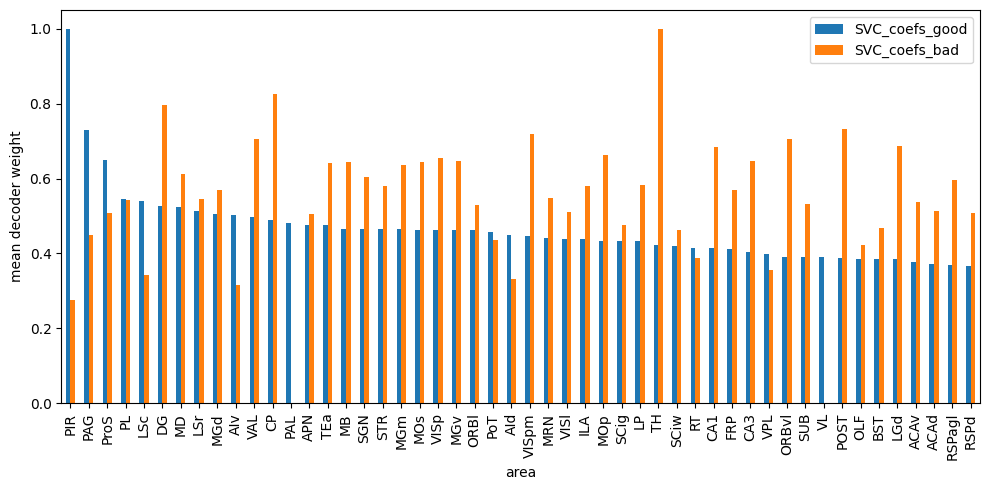

In [59]:
#plot coefs for each area

#sort by svc coef

sorted_df=area_coefs_df.query('n_good_sessions >= 3 and n_total_units_good>=60').sort_values(by='SVC_coefs_good',ascending=False)

sorted_df['LDA_coefs_good']=sorted_df['LDA_coefs_good']/sorted_df['LDA_coefs_good'].max()
sorted_df['SVC_coefs_good']=sorted_df['SVC_coefs_good']/sorted_df['SVC_coefs_good'].max()

sorted_df['LDA_coefs_bad']=sorted_df['LDA_coefs_bad']/sorted_df['LDA_coefs_bad'].max()
sorted_df['SVC_coefs_bad']=sorted_df['SVC_coefs_bad']/sorted_df['SVC_coefs_bad'].max()

fig,ax=plt.subplots(1,1,figsize=(10,5))
sorted_df.iloc[:50].plot.bar(x='area',y=['SVC_coefs_good','SVC_coefs_bad'],ax=ax)#'LDA_coefs_good'],ax=ax)

ax.set_ylabel('mean decoder weight')
# # ax.set_xlabel('area')
# ax.legend(['DR','Templ'])

# ax.set_ylim([-0.03,0.18])
fig.tight_layout()


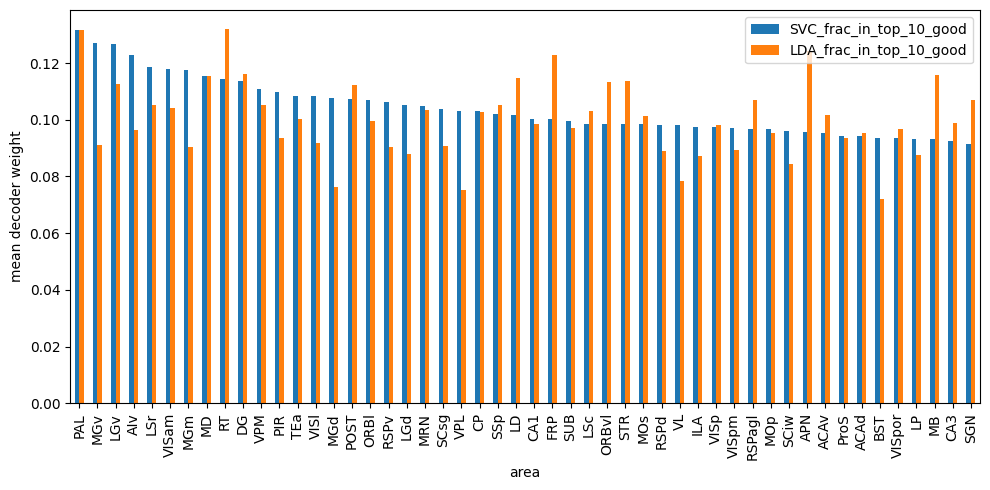

In [52]:
#plot coefs for each area

#sort by svc coef

sorted_df=area_coefs_df.query('n_good_sessions >= 3 and n_total_units_good>=60').sort_values(by='SVC_frac_in_top_10_good',ascending=False)

fig,ax=plt.subplots(1,1,figsize=(10,5))
sorted_df.iloc[:50].plot.bar(x='area',y=['SVC_frac_in_top_10_good','LDA_frac_in_top_10_good'],ax=ax)

ax.set_ylabel('mean decoder weight')
# # ax.set_xlabel('area')
# ax.legend(['DR','Templ'])

# ax.set_ylim([-0.03,0.18])
fig.tight_layout()

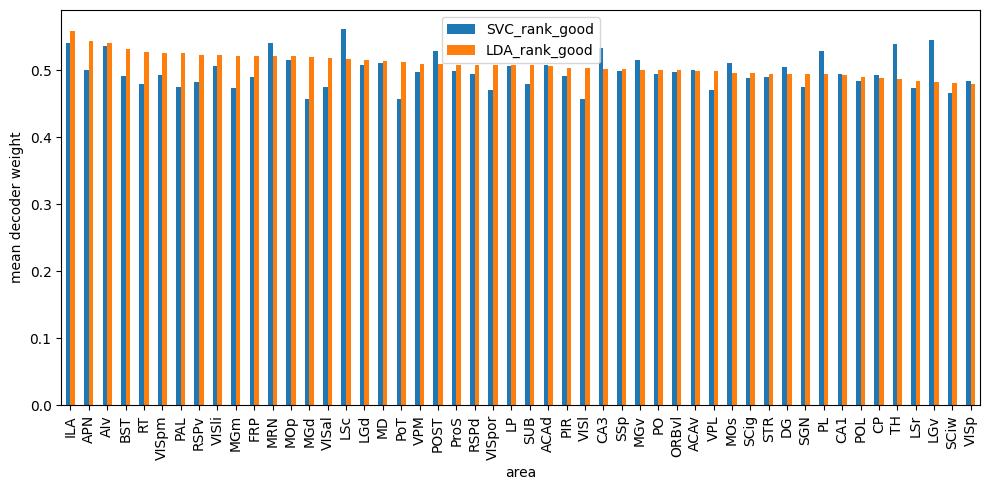

In [53]:
#plot coefs for each area

#sort by svc coef

sorted_df=area_coefs_df.query('n_good_sessions >= 3 and n_total_units_good>=60').sort_values(by='LDA_rank_good',ascending=False)

fig,ax=plt.subplots(1,1,figsize=(10,5))
sorted_df.iloc[:50].plot.bar(x='area',y=['SVC_rank_good','LDA_rank_good'],ax=ax)

ax.set_ylabel('mean decoder weight')
# # ax.set_xlabel('area')
# ax.legend(['DR','Templ'])

# ax.set_ylim([-0.03,0.18])
fig.tight_layout()

In [ ]:
session_list=list(decoder_results.keys())
use_half_shifts=False
has_repeats=True

all_bal_acc={}
linear_shift_dict={
    'session_id':[],
    'project':[],
    'area':[],
    'true_accuracy':[],
    'null_accuracy_mean':[],
    'null_accuracy_median':[],
    'null_accuracy_std':[],
    'p_value':[],
    'ccf_ap_mean':[],
    'ccf_dv_mean':[],
    'ccf_ml_mean':[],
    'n_units':[],
    'probe':[],
    'cross_modal_dprime':[],
    'n_good_blocks':[],
}

#loop through sessions
for session_id in session_list:
    session_info=npc_lims.get_session_info(session_id)
    try:
        performance=pd.read_parquet(
                    npc_lims.get_cache_path('performance',session_info.id,version='any')
                )
    except:
        continue

    if session_info.is_annotated==False:
        continue

    all_bal_acc[session_id]={}


    shifts=decoder_results[session_id]['shifts']
    #extract results according to the trial shift
    half_neg_shift=np.round(shifts.min()/2)
    half_pos_shift=np.round(shifts.max()/2)
    # half_shifts=np.arange(-half_neg_shift,half_pos_shift+1)
    half_neg_shift_ind=np.where(shifts==half_neg_shift)[0][0]
    half_pos_shift_ind=np.where(shifts==half_pos_shift)[0][0]
    half_shift_inds=np.arange(half_neg_shift_ind,half_pos_shift_ind+1)

    all_bal_acc[session_id]['shifts']=shifts
    all_bal_acc[session_id]['half_shift_inds']=half_shift_inds
    if use_half_shifts:
        half_shifts=shifts[half_shift_inds]
    else:
        half_shifts=shifts
    
    areas=decoder_results[session_id]['areas']

    #save balanced accuracy by shift
    for aa in areas:
        if aa in decoder_results[session_id]['results']:
            if use_half_shifts==False:
                half_shift_inds=np.asarray(list(decoder_results[session_id]['results'][aa]['shift'].keys()))
                half_shifts=shifts[half_shift_inds]
            all_bal_acc[session_id][aa]=[]
            for sh in half_shift_inds:
                all_bal_acc[session_id][aa].append(decoder_results[session_id]['results'][aa]['shift'][sh]['balanced_accuracy'])
            all_bal_acc[session_id][aa]=np.array(all_bal_acc[session_id][aa])

            if type(aa)==str:
                if '_probe' in aa:
                    area_name=aa.split('_probe')[0]
                    probe_name=aa.split('_probe')[1]
                else:
                    area_name=aa
                    probe_name=''
            else:
                area_name=aa
            
            true_acc_ind=np.where(half_shifts==1)[0][0]
            null_acc_ind=np.where(half_shifts!=1)[0]
            true_accuracy=all_bal_acc[session_id][aa][true_acc_ind]
            null_accuracy_mean=np.mean(all_bal_acc[session_id][aa][null_acc_ind])
            null_accuracy_median=np.median(all_bal_acc[session_id][aa][null_acc_ind])
            null_accuracy_std=np.std(all_bal_acc[session_id][aa][null_acc_ind])
            p_value=np.mean(all_bal_acc[session_id][aa][null_acc_ind]>=true_accuracy)

            #make big dict/dataframe for this:
            #save true decoding, mean/median null decoding, and p value for each area/probe
            linear_shift_dict['session_id'].append(session_id)
            linear_shift_dict['project'].append(session_projects.query('session==@session_id')['project'].values[0])
            linear_shift_dict['area'].append(area_name)
            linear_shift_dict['true_accuracy'].append(true_accuracy)
            linear_shift_dict['null_accuracy_mean'].append(null_accuracy_mean)
            linear_shift_dict['null_accuracy_median'].append(null_accuracy_median)
            linear_shift_dict['null_accuracy_std'].append(null_accuracy_std)
            linear_shift_dict['p_value'].append(p_value)

            linear_shift_dict['cross_modal_dprime'].append(performance['cross_modal_dprime'].mean())
            linear_shift_dict['n_good_blocks'].append(np.sum(performance['cross_modal_dprime']>=1.0))

            # 'ccf_ap_mean', 'ccf_dv_mean', 'ccf_ml_mean'
            if 'ccf_ap_mean' in decoder_results[session_id]['results'][aa].keys():
                linear_shift_dict['ccf_ap_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ap_mean'])
                linear_shift_dict['ccf_dv_mean'].append(decoder_results[session_id]['results'][aa]['ccf_dv_mean'])
                linear_shift_dict['ccf_ml_mean'].append(decoder_results[session_id]['results'][aa]['ccf_ml_mean'])
                linear_shift_dict['n_units'].append(decoder_results[session_id]['results'][aa]['n_units'])
                linear_shift_dict['probe'].append(probe_name)
            else:
                linear_shift_dict['ccf_ap_mean'].append(np.nan)
                linear_shift_dict['ccf_dv_mean'].append(np.nan)
                linear_shift_dict['ccf_ml_mean'].append(np.nan)
                linear_shift_dict['n_units'].append(np.nan)
                linear_shift_dict['probe'].append(np.nan)

    
linear_shift_df=pd.DataFrame(linear_shift_dict)
linear_shift_df.to_csv(os.path.join(loadpath,'combined','all_unit_linear_shift_use_more_trials.csv'))